In [169]:
import os
import re
import boto3
import itertools
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sagemaker.session import Session

In [2]:
# create a darker background template (better for my eyes)
from jupyterthemes.stylefx import set_nb_theme
# set_nb_theme('chesterish')

## Helper Functions & Classes

In [3]:
# small class for holding "special" print flags
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [4]:
def QAcheck(tests, checks, func):
    """
    Quality-assurance checks for expected outputs, and function outputs
    """
    for index, test in enumerate(tests):
        value = func(test)
        
        if type(value) == np.ndarray:  
            if (value == checks[index]).all():
                print('Correct Match\t{} = {}'.format(tests[index], checks[index]))
        else:
            if (value is checks[index]):
                print('Correct Match\t{} = {}'.format(tests[index], checks[index]))
            elif (value == checks[index]):
                print('Correct Match\t{} = {}'.format(tests[index], checks[index]))
            else:
                print(color.BOLD,color.RED,'ERROR MATCH\t{} /= {}'.format(tests[index], checks[index]),color.END)

In [5]:
def cleanNumeric(value) -> float:
    """
    This function converts a string to a numeric quantity, handles weird string format
    :param: value, string value with hidden numeric quanity  
    :return: floating point values
    
    Complexity -> O(n)
    
    e.g.
        In[0]: $ 19,225     ->   Out[0]: 19255
        In[0]: $ 19,225.76  ->   Out[0]: 19255.76
        
    """
    
    assert type(value) is str or int or np.ndarray, 'Value must be of type string, integer, float or numpy array'
    
    # checks to see what type of value is being provided
    operator = type(value)
    
    def num_strip(number):
        """
        Nested function for extracting numerical quantities
        """
        try:
            # some accounting formats take () to be negative numbers
            if number[0] == '(':
                number = '-' + number

            # perform regex operation scanning for only numeric quantities/identifiers
            cleanValue = re.sub("[^0-9|.|-]", "", number)

            # last check against poor lagging formats e.g. "." or "-" to return nan or floating-point number
            try: 
                return float(cleanValue)
            except ValueError: 
                return np.nan
            
        except (TypeError, IndexError):
            return np.nan
    
    # if provided a string, perform regex operation 
    if (operator is str) and (len(value) > 0):
        return num_strip(value)
    
    # if operator is integer then simply return the value, no need to modify 
    elif (operator is int):
        return value
    
    # if operator is numpy array then we perform a extraction per element in array
    elif (operator is np.ndarray):
        vFunc = np.vectorize(num_strip)      # vectorize function to apply to numpy array
        cleanValue = vFunc(value)            # apply vector function
        return cleanValue
    
    else:
        return np.nan

In [6]:
tests = np.array(['', '$.', '$ -', '.3', '128,123', '-$24,613', '(21,843)', '$212,223',
                 np.array(['$13,300', '-$2344', '$23,421']), np.array(['$13,300', np.nan, '$23,421']),
                 np.array([np.nan, np.nan])])
expectation = np.array([np.nan, np.nan, np.nan, 0.3, 128123.0, -24613.0, -21843.0, 212223.0, 
                        [13300., -2344., 23421.], [13300., np.float64(np.nan), 23421.], 
                        [np.float64(np.nan), np.float64(np.nan)]])

QAcheck(tests, expectation, cleanNumeric)

Correct Match	 = nan
Correct Match	$. = nan
Correct Match	$ - = nan
Correct Match	.3 = 0.3
Correct Match	128,123 = 128123.0
Correct Match	-$24,613 = -24613.0
Correct Match	(21,843) = -21843.0
Correct Match	$212,223 = 212223.0
Correct Match	['$13,300' '-$2344' '$23,421'] = [13300.0, -2344.0, 23421.0]


In [7]:
def regexCheck(string:str, searchTerm:str):
    """
    Checks a regex expression for a given string construct
    string (type str)
        A string to perform a regex search on e.g. "Cash and cash equiavalents"
    searchTerm (type str)
        A regex expression to execute a search e.g. "^Cash"
        
    return: the searched term in question
    """
    try:
        s = re.search(searchTerm, string, flags=re.I)
        return s.string
    except AttributeError:
        return None

In [8]:
# sample = "Total Liabilities stockholder's equity"
sample = "MEMBER'S EQUITY"
regexCheck(sample, '^(?!.*liabilities).*equity$')

"MEMBER'S EQUITY"

In [9]:
def tMatch(totalA:float, totalLE:float):
    # helps match the accounting equation assets = libabilities + equities 
    try:
        multiplier = totalA / totalLE
        
        # if multiplier is zero, then total asset column is zero, we return nothing (imperfect)
        if multiplier == 0: return (None, 'Asset table is missing')
        
        # if multiplier is non-negative we accept only 1 or multiples of 10 (perfect and semi-perfect)
        elif (multiplier == 1) or (multiplier%10 == 0): return (multiplier, 'Perfect/Semi-Perfect match')
        
        # all other multipliers, should return nothing (number mismatch) 
        else: return (None, 'Accounting Error')
        
    # if total liabilites doesn't exist, but total assets either exists or does not exist  
    except ZeroDivisionError:
        return (None, "Either Liabilities/Equities doesn't exist or both Total Assets and Liabilities/Equities missing")

In [10]:
print(tMatch(totalA=0, totalLE=100))
print(tMatch(totalA=0, totalLE=0))
print(tMatch(totalA=100, totalLE=0))
print(tMatch(totalA=100, totalLE=100))
print(tMatch(totalA=10000, totalLE=100))
print(tMatch(totalA=102020, totalLE=11))

(None, 'Asset table is missing')
(None, "Either Liabilities/Equities doesn't exist or both Total Assets and Liabilities/Equities missing")
(None, "Either Liabilities/Equities doesn't exist or both Total Assets and Liabilities/Equities missing")
(1.0, 'Perfect/Semi-Perfect match')
(100.0, 'Perfect/Semi-Perfect match')
(None, 'Accounting Error')


## Interact with System Environment

In [11]:
# initiate s3 bucket and corresponding data folder
bucket = "ran-s3-systemic-risk"
data_folder ="Output/BalanceSheet/"

# Amazon Textract client and Sagemaker session
textract = boto3.client('textract')
s3 = boto3.client('s3')
session = Session()

# discover all of the pdfs that you want to parse
paths = np.array(session.list_s3_files(bucket, data_folder))

In [12]:
print('Total cleaned .csv files total {}'.format(paths.size-1))

Total cleaned .csv files total 13254


## Test Case Example

In [12]:
selections = np.random.choice(paths[1:], 100)

In [13]:
index = 40

In [14]:
# retrieving downloaded files from s3 bucket
s3.download_file(bucket, selections[index], 'temp.pdf')

df = pd.read_csv('temp.pdf')

In [15]:
# complete .csv file read from the 
df

,Unnamed: 0,0,1
0,0,Cash,"$ 39,499"
1,1,Due from Clearing Broker,"242,638,316"
2,2,"Securities owned, at market value (Note 5)","38,087,111"
3,3,JBO investment,"50,000"
4,4,Equipment (net of accumulated depreciation of ...,"151,499"
5,5,Leasehold improvements (net of accumulated amo...,"31,172"
6,6,TOTAL ASSETS,"$ 280,997,597"
7,7,LIABILITIES AND MEMBERS' EQUITY,NaN
8,8,Accounts payable and accrued expenses,"$ 128,392"
9,9,"Securities sold, not yet purchased, at market","243,570,454"


In [16]:
# clean dataframes for only the items and their immediate values
cleanDf = df[df.columns[1:3]].dropna() 

In [17]:
cleanDf['1'] = cleanDf['1'].apply(cleanNumeric)

In [18]:
cleanDf

,0,1
0,Cash,39499.0
1,Due from Clearing Broker,242638316.0
2,"Securities owned, at market value (Note 5)",38087111.0
3,JBO investment,50000.0
4,Equipment (net of accumulated depreciation of ...,151499.0
5,Leasehold improvements (net of accumulated amo...,31172.0
6,TOTAL ASSETS,280997597.0
8,Accounts payable and accrued expenses,128392.0
9,"Securities sold, not yet purchased, at market",243570454.0
10,TOTAL LIABILITIES,243698846.0


In [19]:
print('Data for {}'.format(selections[index]))

Data for Output/BalanceSheet/1049854-03.csv


In [20]:
def extraction(df:pd.DataFrame, file:str) -> pd.DataFrame:
    """
    Extract specific line items from cleaned dataframes (balance sheets)
    :param: df (type pd.DataFrame)
        The dataframe from
    :param: file (type str)
        The file string stored in the s3 bucket
    
    :return: A dataframe subset with critical lines extracted
    """
    
    # regex expression for searching for line items 
    keySearch = ['^cash', 'deposits', 'receivable', '^total assets', 'payable', 'total liabilities$', 'common stock', 
                 'preferred stock', 'earnings', '^(?!.*liabilities).*equity$|^(?!.*liabilities).*equity:$', 
                 '^total liabilities.*equity$|^total liabilities.*equity:$']
    
    # key names reflecting the corresponding the regex names
    keyNames = ['Cash & Equivalents', 'Deposits', 'Receivables', 'Total Assets', 'Payables', 'Total Liabilities',
                'Common Stock', 'Preferred Stock', 'Earnings', 'Total Equity', 'Total Liabilities & Equity']
    
    # concat the list of dataframe for each extraction 
    series = {}
    
    # creating two rows to track the CIK and year information released
    cik, year = file.split('/')[-1].split('-')
    
    series['CIK'] = cik          # CIK number for firm 
    series['Year'] = year[:2]    # Year for firm filing  
    
    # select key for search names
    for i, key in enumerate(keySearch):
        # filter regex for corresponding string expression
        filterSet = df[df.columns[0]].str.contains(key, regex=True, flags=re.IGNORECASE)
        
        # matching names for search and constructing a row (dictionary form)
        # filter dataframe and sum corresponding data column
        series[keyNames[i]] = df[filterSet][df.columns[1]].sum()
  
    # match the T-table, asset/liabilities/equity for rows
    mul, msg = tMatch(series['Total Assets'], series['Total Liabilities & Equity'])
    
    if mul != None:
        series['Total Liabilities & Equity'] = series['Total Liabilities & Equity'] * mul
        
        # computing the series for other available line item
        series['Other Assets'] = series['Total Assets'] - series['Cash & Equivalents'] - series['Deposits'] - series['Receivables']
        series['Other Liabilities'] = series['Total Liabilities'] - series['Payables']
        series['Other Equity'] = series['Total Equity'] - series['Common Stock'] - series['Preferred Stock'] - series['Earnings']

        # convert the filtered dictionaries to a dataframe
        comboDF = pd.DataFrame.from_dict(series, orient='index')

        return comboDF.transpose()
    else:
        return msg

In [21]:
extraction(cleanDf, selections[index])

,CIK,Year,Cash & Equivalents,Deposits,Receivables,Total Assets,Payables,Total Liabilities,Common Stock,Preferred Stock,Earnings,Total Equity,Total Liabilities & Equity,Other Assets,Other Liabilities,Other Equity
0,1049854,03,39499,0,0,2.80998e+08,128392,2.43699e+08,0,0,0,3.72988e+07,2.80998e+08,2.80958e+08,2.4357e+08,3.72988e+07


# X-17A-5 Database Construction

In [76]:
# subsample of path-objects to observe
obsRange = paths[1:500]

## Balance Sheet item extraction
**We start by retrieving all asset line items as well as liability & equity line items**

In [209]:
def balanceSheetLines(fileNames:np.ndarray) -> tuple:
    """
    Retrieving balance sheet information line item names for s3 files
    :param: (type np.ndarray)
        An array of file names for .csv files from s3
        
    :return: (type tuple)
        Return a tuple of arrays; left is the asset items, and right is the liability & equity items 
    """
    
    # initialize asset and liability list to store items
    Asset = []
    LiabilityandEquity = []

    # iterate through files from s3 bucket 
    for file in fileNames:
        
        # download temporary file from s3 bucket
        s3.download_file(bucket, file, 'temp.pdf')
        df = pd.read_csv('temp.pdf')
        
        n = df.columns.size   # the number of columns in read dataframe
        
        if n > 1: # if there is more than 1 column we continue examination 
            
            arr = df[df.columns[1]].dropna().values     # all line item for balance sheet (second column)
            
            # iterate through the line items as provided by the array
            for i, item in enumerate(arr):
                
                # search string for presence of word 'liabilties' or 'liability' 
                val = re.search('liabilities|liability ', item, flags=re.I)
                
                # if we find the term 'liability' or 'liabilities' we split the line items and break inner loop
                if val is not None:
                    
                    # partition by the enumerated index for asset and liability portions
                    Asset.append(arr[:i])
                    LiabilityandEquity.append(arr[i:])
                    break
                    
        # remove local file after it has been created
        os.remove('temp.pdf')
    
    # flatten series for all values
    left = np.hstack(np.array(Asset))
    right = np.hstack(np.array(LiabilityandEquity))
    
    return (left, right)

In [78]:
leftSide, rightSide = balanceSheetLines(obsRange)

In [211]:
# storing unique list of asset items and liability line items
with open('assetLines.txt', 'w') as f: json.dump(list(set(leftSide)), f)
with open('liabilityLines.txt', 'w') as f: json.dump(list(set(rightSide)), f)

print('All line items have been stored from balance sheet reading\n\tAsset items are stored\n\tLiability & Equity items are stored')

All line items have been stored from balance sheet reading
	Asset items are stored
	Liability & Equity items are stored


## Unstructured Data formulation
**Use the extracted asset and liaiblity lines to construct a large panel dataset, where line items are columns**

In [80]:
with open('assetLines.txt', 'r') as f: assetSide = json.loads(f.read())
with open('liabilityLines.txt', 'r') as f: liableSide = json.loads(f.read())
    
print('Asset and Liabilities & Equity lines have been loaded in from JSON')

Asset and Liabilities & Equity lines loaded


In [81]:
assetDict = dict([(i, np.nan) for i in assetSide])
liableDict = dict([(i, np.nan) for i in liableSide])

In [294]:
def unstructured_data(filepaths, lineDictionary, lineItems) -> tuple:
    """
    Forms unstructured data frame from .csv file(s) located in s3 bucket
    
    :param: filepaths
        filepaths from s3 that store .csv file(s) (Output/BalanceSheet/)
    :paran: lineDictionary
        dictionary of total unstructured line items and corresponding values
    :paran: lineItems
        list of line items (asset/liabilites) that will be searched for
        
    :return: tuple
        Returns a tuple, itters is a list of dataframes representing line items, error is a dictionary
        tracking all error terms that exist due to univariate dataframes 
    """
    
    # intialize list to store dataframes and errors
    itters = []
    error = {}

    # iterate through files from s3 
    for file in filepaths:
        
        # create temporary dictionary copy for storage of values
        tempDict = lineDictionary.copy()
          
        # creating two rows to track the CIK and year information released
        cik, year = file.split('/')[-1].split('-')

        tempDict['CIK'] = cik                 # CIK number for firm 
        tempDict['Year'] = '20' + year[:2]    # Year for firm filing  
        
        # retrieving downloaded files from s3 bucket
        s3.download_file(bucket, file, 'temp.pdf')
        df = pd.read_csv('temp.pdf')

        # clean dataframes for only the items and their immediate values
        cleanDF = df[df.columns[1:]] 

        # clean dataframe should be of size greater than 1
        if len(cleanDF.columns) > 1:
            
            # extract line items from each dataframe (balance sheet)
            lines = cleanDF[cleanDF.columns[0]]
            
            # filter dataframes according line items, and extract numerical values from dataframe 
            filterDF = cleanDF[np.isin(lines, lineItems)]
            filterDF = filterDF.set_index(filterDF.columns[0])             # set line items as index
            filterDF = filterDF.apply(lambda x: cleanNumeric(x.values))    # extract numerical figures

            # iterate through items from (asset or liability items)
            for item in filterDF.index:
                lineVal = filterDF.loc[item]                 # line item e.g. Cash $72,343 $71,231
                
                # check to see scope of line value, checking if multi-columns present
                # in the event we have repeating 'item' lines (e.g. 2 Prepaid expense) we sum columns  
                if type(lineVal) is not pd.Series:
                    lineVal = lineVal.sum()
                
                value = lineVal.iloc[0]                      # first column value e.g. 72343
                
                # value of line items for the adjacent column (current year)
                if ~np.isnan(value):
                    tempDict[item] = value
                    
                else:
                    try:
                        # if the first column is blank we assume the second column is filled with totals
                        value = lineVal.iloc[1]
                        
                        # if second column value is not-nan we attach those values
                        if ~np.isnan(value):
                            tempDict[item] = value
                    
                    # if no second column exists, we ignore and pass
                    except IndexError: pass
            
            # convert the dictionary values to dataframe for database construction 
            row = pd.DataFrame.from_dict(tempDict, orient='index')
            
            # append dataframe set to array transposing 
            itters.append(row.transpose())
            
        else:
            error[file] = 'Issue reading PDF'
        
        # remove local file after it has been created
        os.remove('temp.pdf')
    
    return itters, error

In [297]:
# the output directory for both asset and liability figures 
assetItters, errors = unstructured_data(obsRange, assetDict, list(assetDict.keys()))
assetDF = pd.concat(assetItters)

liableItters, errors = unstructured_data(obsRange, liableDict, list(liableDict.keys()))
liableDF = pd.concat(liableItters)

In [298]:
# re-order the CIK and Year columns to appear as the first two columns
remap = assetDF.columns[~np.isin(assetDF.columns, ['CIK', 'Year'])]
unstructADF = assetDF[np.insert(remap, [0, 0], ['CIK', 'Year'])]

In [299]:
# filter out columns with NaN values, return only values
filterNaN = unstructADF.isnull().all()
cleanCols = filterNaN[filterNaN == False].index

In [300]:
unstructADF[cleanCols].head()

,CIK,Year,"(Net of accumulated depreciation and amortization of $475,741)",Receivable from affiliate,"Furniture, equipment and leasehold improvements, at cost, less accumulated depreciation and amortization of $431 (Note 5)","Securities owned, at fair value",Investments,Deferred tax asset (Note 8),Receivable from affiliates (Note 6),Accounts receivable - trade,...,Interest and dividends receivable,Payable to Affiliate,Deposit at clearing broker,Clearing deposit with broker dealer,Receivable from related party,Total Assets,Receivable from Non-Customer,Equity securities,Accounts Receivable,"Securities, at fair value"
0,1000147,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1000147,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1000147,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1000147,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1000147,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [301]:
unstructADF[cleanCols].to_csv('unstructAssetSample.csv', index=False)

In [302]:
# re-order the CIK and Year columns to appear as the first two columns
remap = liableDF.columns[~np.isin(liableDF.columns, ['CIK', 'Year'])]
unstructLDF = liableDF[np.insert(remap, [0, 0], ['CIK', 'Year'])]

In [303]:
# filter out columns with NaN values, return only values
filterNaN = unstructLDF.isnull().all()
cleanCols = filterNaN[filterNaN == False].index

In [304]:
unstructLDF[cleanCols].head()

,CIK,Year,10 shares issued and outstanding),Accrued commissions and clearance charges,Due to To Shareholder,"Common stock, no par value, 1,000 shares authorized and 100 shares issued and outstanding",Additional paid-in-capital,Payables to affiliates (Note 6),Total liabilities and members' equity,Income taxes payable to parent,...,Bank overdrafts,Payable to Affiliate,"Securites sold, not yet purchased",MEMBERS' EQUITY,Net Income,Paid in capital,Bank overdraft,Additional Paid in Capital,Total Liabilities and Shareholder's Equity,Liability and Shareholder's Equity Liability: Due to Parent Company
0,1000147,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4200
0,1000147,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1000147,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1000147,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1000147,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [305]:
unstructLDF[cleanCols].to_csv('unstructLiableSample.csv', index=False)

## Line Item Label Clustering
**Using KMeans clustering for determing word similitaries amongst balance sheet items**

In [13]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AffinityPropagation, KMeans, AgglomerativeClustering

In [84]:
def word_matching(array: np.array, vectorizer_class, cluster_class) -> tuple:
    
    # Convert a collection of text documents to a matrix of token counts
    vectorizer = vectorizer_class
    print('Using the {} text vectorizer\n'.format(type(vectorizer_class).__name__))
    
    # produces a sparse representation of the counts using scipy.sparse.csr_matrix.
    X = vectorizer.fit_transform(array)
    
    # initialize the clustering model on words
    model = cluster_class
    
    model.fit(X)  # fit clustering model to array of strings

    # returns dataframe, mapping cluster labels to line items
    outDF = pd.DataFrame({'Labels': model.labels_, 'LineItems': array})
    
    print('\n{} clusters were found using {} algorithm'.format(model.labels_.max()+1, type(cluster_class).__name__))
    
    return model.labels_, model.cluster_centers_, outDF 

In [15]:
# reading cleaned unstructured data sets for samples 
assets = pd.read_csv('unstructAssetSample.csv')
liability = pd.read_csv('unstructLiableSample.csv')

**The following clustering model specifications are outlined below:**

- **array:** We select the columns from either asset or liability tables, not including CIK or Year components.
- **vectorizer_class:** We implement a standard TfidVectorizer class, converting the collection of strings to a matrix of TF-IDF features.

- **cluster_class:** We fit a KMeans clustering algorithm, employing **35 cluster** using the the classic **expectation–maximization algorithm (full)** for computing the KMeans clusters with **25 centroid seeds** to check against. We also control the random state and provided verbosity to model fits

In [81]:
clusters = 35
text_vectorizer = TfidfVectorizer(lowercase=True)
cluster_mdl = KMeans(n_clusters=clusters, n_init=25, verbose=1, random_state=1, algorithm='full')

In [85]:
# perform clustering on the asset line items
assetlabel, assetCenters, df1 = word_matching(array = assets.columns[2:], vectorizer_class = text_vectorizer, 
                                              cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration  0, inertia 509.192
Iteration  1, inertia 318.223
Iteration  2, inertia 313.231
Iteration  3, inertia 311.602
Iteration  4, inertia 311.049
Iteration  5, inertia 310.992
Iteration  6, inertia 310.854
Iteration  7, inertia 310.747
Converged at iteration 7: center shift 0.000000e+00 within tolerance 2.142878e-07
Initialization complete
Iteration  0, inertia 495.014
Iteration  1, inertia 319.950
Iteration  2, inertia 313.737
Iteration  3, inertia 310.787
Iteration  4, inertia 309.397
Iteration  5, inertia 308.914
Iteration  6, inertia 308.833
Iteration  7, inertia 308.728
Iteration  8, inertia 308.527
Iteration  9, inertia 308.228
Iteration 10, inertia 308.155
Iteration 11, inertia 308.078
Converged at iteration 11: center shift 0.000000e+00 within tolerance 2.142878e-07
Initialization complete
Iteration  0, inertia 502.186
Iteration  1, inertia 315.469
Iteration  2, inertia 309.511
Iteration  3, inertia 308.054


In [86]:
# perform clustering on the liability & equity line items
liabilitylabel, liabilityCenters, df2 = word_matching(array = liability.columns[2:], vectorizer_class = text_vectorizer, 
                                                      cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration  0, inertia 359.642
Iteration  1, inertia 238.229
Iteration  2, inertia 233.877
Iteration  3, inertia 229.614
Iteration  4, inertia 227.873
Iteration  5, inertia 227.611
Converged at iteration 5: center shift 0.000000e+00 within tolerance 3.330269e-07
Initialization complete
Iteration  0, inertia 356.595
Iteration  1, inertia 236.836
Iteration  2, inertia 232.680
Iteration  3, inertia 227.819
Iteration  4, inertia 226.632
Iteration  5, inertia 226.300
Iteration  6, inertia 225.842
Iteration  7, inertia 224.922
Iteration  8, inertia 224.814
Converged at iteration 8: center shift 0.000000e+00 within tolerance 3.330269e-07
Initialization complete
Iteration  0, inertia 370.310
Iteration  1, inertia 235.241
Iteration  2, inertia 226.518
Iteration  3, inertia 223.959
Iteration  4, inertia 222.762
Iteration  5, inertia 222.629
Converged at iteration 5: center shift 0.000000e+00 within tolerance 3.330269e-07
Initializ

### Examination of Clusters Realiablity
**Observing the distance between cluster centroids, tracking numerical difference relative to other labels**

In [167]:
def distance_matrix(centers: np.ndarray):
    clusters, nfeatures  = centers.shape
    itRange = np.arange(clusters)
    
    # similar to covariance matrix, initialize memory for distance matrix
    dMat = np.zeros((clusters, clusters))
    
    for i in itRange:
        for j in itRange:
            # computing the distance between centroids to examine label closeness
            distance = np.sqrt(np.sum(np.square(centers[i, :] - centers[j, :])))
            
            # assign values to the corresponding distance matrix
            dMat[i, j] = distance
    
    return dMat

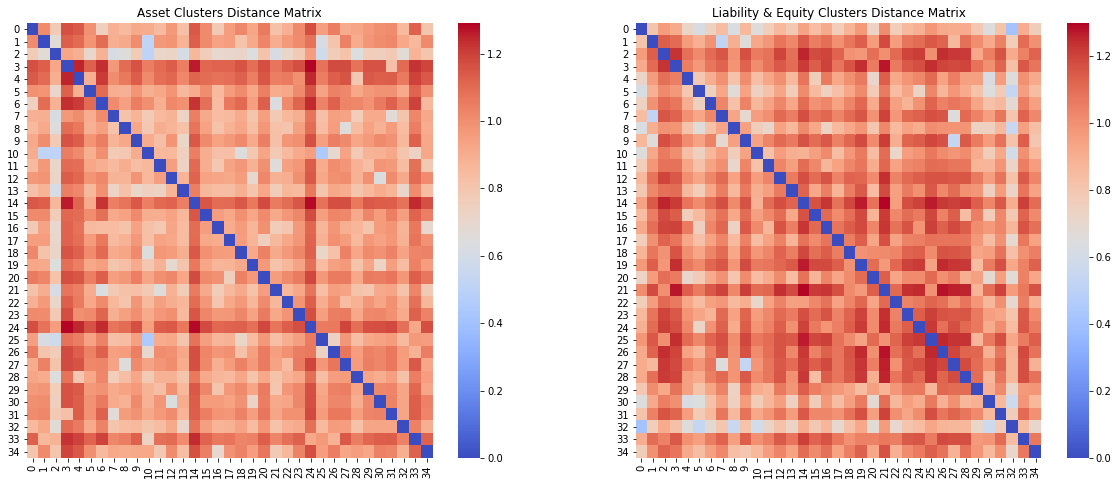

In [190]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
sns.heatmap(distance_matrix(assetCenters), cmap='coolwarm', ax=axes[0])
sns.heatmap(distance_matrix(liabilityCenters), cmap='coolwarm', ax=axes[1])
axes[0].set_title('Asset Clusters Distance Matrix')
axes[1].set_title('Liability & Equity Clusters Distance Matrix')
plt.show()

Clustering works to great effect with the vast majority of cases presented, but there still appears to be issues that persist when trying to divide the current dataset - namely more nuanced differences such as "Total Liabilites and Equity" and "Total Equity". I want to try grouping these and then clustering them again.

In [192]:
# creating names for assest line clusters
for i in range(df2.Labels.max()+1):
    print('Label', i)
    cluster_cells = df2[df2.Labels == i]['LineItems'].values
    print(cluster_cells)
    print()

Label 0
['4. Corporate obligations' '0701-0795882'
 "1. Bankers' acceptance, certificates of deposit, and"
 'Refundable deposit' '3. State and municipal government obligations'
 '2. U.S. and Canadian government obligations' 'A. Clearance account'
 'D. Undue concentration' 'Obligations under capitalized leases'
 'Deferred affilation fee' 'Book Overdraft']

Label 1
['and 100 shares issued and outstanding'
 '200 shares authorized - NPV 100 shares issued & outstanding'
 'authorized, 100 issued and outstanding'
 'authorized, 414,836 shares issued and outstanding'
 '100 shares issued & outstanding'
 'authorized, 475,406 shares issued and outstanding'
 'authorized, 271,772 shares issued and outstanding'
 'authorized, issued and outstanding)'
 'authorized, 277,284 shares issued and outstanding'
 'authorized 200 shares; issued and outstanding 100 shares'
 'authorized, 230,100 shares' '100 issued and outstanding'
 'authorized, 230,100 shares issued and outstanding'
 '100 shares issued and outsta

In [205]:
# selecting all clusters with total liability and equity line items to re-run smaller clustering 
Lsubset = df2[np.isin(df2.Labels, [2, 18, 19, 21, 25, 29, 33])]['LineItems'].values

lSubDF = word_matching(array = Lsubset, vectorizer_class = text_vectorizer, 
                       cluster_class = KMeans(n_clusters=3, n_init=25, verbose=1, random_state=1, algorithm='full'))

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration  0, inertia 85.078
Iteration  1, inertia 54.166
Iteration  2, inertia 53.731
Iteration  3, inertia 53.182
Converged at iteration 3: center shift 0.000000e+00 within tolerance 2.855347e-06
Initialization complete
Iteration  0, inertia 78.315
Iteration  1, inertia 50.691
Iteration  2, inertia 50.587
Iteration  3, inertia 50.522
Iteration  4, inertia 50.464
Iteration  5, inertia 50.413
Converged at iteration 5: center shift 0.000000e+00 within tolerance 2.855347e-06
Initialization complete
Iteration  0, inertia 89.674
Iteration  1, inertia 55.131
Iteration  2, inertia 55.050
Converged at iteration 2: center shift 0.000000e+00 within tolerance 2.855347e-06
Initialization complete
Iteration  0, inertia 81.383
Iteration  1, inertia 52.891
Iteration  2, inertia 52.411
Iteration  3, inertia 51.978
Iteration  4, inertia 51.907
Converged at iteration 4: center shift 0.000000e+00 within tolerance 2.855347e-06
Initializat

In [208]:
for i in range(lSubDF[2].Labels.max()+1):
    print('Label', i)
    cluster_cells = lSubDF[2][lSubDF[2].Labels == i]['LineItems'].values
    print(cluster_cells)
    print()

Label 0
['Total' "Total shareholder's equity"
 "TOTAL LIABILITIES AND SHAREHOLDERS' DEFICIT"
 "Total liabilities and shareholders' equity"
 "Total liabilities and stockholders' equity"
 'Total capital and allowable subordinated liabilities'
 'TOTAL CURRENT LIABILITIES AND TOTAL LIABILITIES'
 "TOTAL SHAREHOLDERS' EQUITY" 'TOTAL' 'Liabilites: Current liabilities'
 "TOTAL LIABILITIES & MEMBER'S EQUITY"
 "TOTAL LIABILITIES AND SHAREHOLDERS' EQUITY"
 "TOTAL LIABILITIES AND SHAREHOLDER'S DEFICIT"
 "TOTAL SHAREHOLDER'S EQUITY" 'Total liabilities and'
 "TOTAL LIABILITIES AND SHAREHOLDER'S" 'Total liabilities'
 "Total Liabilities and Stockholders' Equity" "TOTAL STOCKHOLDERS' EQUITY"
 'Total Liabilities' "TOTAL LIABILITIES AND MEMBER'S CAPITAL"
 'TOTAL STOCKHOLDERS EQUITY' "Total Shareholder's Equity (Deficit)"
 'TOTAL CURRENT LIABILITIES'
 "TOTAL LIABILITIES AND SHAREHOLDER' S EQUITY (DEFICIT)"
 "Total shareholders' equity" 'TOTAL LIABILITIES AND SHAREHOLDERS EQUITY'
 "Total liabilities and sh

As exhbited above, repeated clustering on a smaller subset of line items does not break it into expected groups. Rather, we arrive at similar breaks that we saw before when using a smaller KMeans cluster set. Hence, I will pursue the LDA as is, and see the label identificaition that follows.

## Latent Dirichlet Allocation with online variational Bayes algorithm
**A Topic Model for root-word detection from a list of similar strings** 

Our goal here is to determine whether using LDA decomposition is useful in determining label names for clustering classes

* The corpus is a collection of **D** documents, which will be a cluster with corresponding word groupings from KMeans
* A document is a sequence of **N** words, which corresponds to the sequence of characters of each word in the cluster
* There are **K** topics in the corpus, which will be one as we are looking to determine roots

In [43]:
from sklearn.decomposition import LatentDirichletAllocation

In [44]:
def label_LDA(names, LDA_model):
    assert type(LDA_model).__name__ is 'LatentDirichletAllocation', 'Model restriction, only imposed LDA'
    
    print('Clustered names provided are:\n\n', names, '\n')
    labelNames = []
    
    # vectorize the text (string) data to be used by Latent Dirichlet Allocation algorithm
    text_mdl = TfidfVectorizer()
    vec_text = text_mdl.fit_transform(names)
    
    # feature names extracted from the TfidVectorizer
    feature_names = text_mdl.get_feature_names()
  
    # fit Laten Dirichlet Allocation model 
    mdl = LDA_model
    mdl.fit(vec_text)
    
    print()
    # print out label names determined from LDA
    for topic in mdl.components_:
        message = "Topic determined: "
        message += " ".join([feature_names[i]
                             # select the 5 most important feature names from largest to smallest order
                             for i in topic.argsort()[:-5 - 1:-1]])
        print(color.BOLD, message, color.END)
        labelNames.append(message)
    print()
    
    return labelNames

Continuing this current assesment of topic detection, we extend this to the entire subset of items computed from the clustering algorithm employed to group each of the asset/liability line items grouped before. **(Refer to KMeans Model for details on clustering)**


In [45]:
# creating names for assest line clusters
for i in range(df1.Labels.max()+1):
    print('Label', i)
    cluster_cells = df1[df1.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['Clearing broker' 'Deposit with clearing broker-dealer'
 'Due from broker-dealer (Notes 1 and 11)'
 'Deposits with clearing broker-dealer'
 'Receivable from clearing broker dealer' 'Receivable from broker'
 'Receivable from broker-dealer' 'Due from broker-dealer (Notes 1 and 10)'
 'Broker-dealer commissions receivable'
 'Receivable from clearing broker/dealer' 'RECEIVABLE FROM BROKER/DEALER'
 'Receivable from broker/dealer' 'Broker-dealer commission receivable'
 'Investment in broker-dealer' 'Receivable from clearing broker'
 'Broker-dealer commissions' 'Payable to clearing broker'
 'BROKER OR DEALER: BLACKHAWK FINANCIAL L.LC.'
 'Receivable from clearing broker-dealer'
 'Clearing deposit with broker dealer'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iterat

iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: deposit clearing security at csc 


Label 9

Clustered names provided are:

 ['Notes receivable (notes 3 and 4)'
 'Receivable from related parties (Note 3)'
 'Receivable from related parties'
 'Accounts Receivable - Related Parties Deposit'
 'Due from related parties' 'Notes Receivable' 'Notes receivable'
 'Accounts receivable - related parties' 'Related party receivable'
 'Notes receivable - related parties'
 'Accounts Receivable - Related Parties' 'Receivable from related party'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter:

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: in cash bank segregated regulations 


Label 18

Clustered names provided are:

 ['Equipment, at cost, less accumulated depreciation of $67 (Note 4)'
 'Equipment, at cost, less accumulated depreciation of $15 (Note 4)'
 'Equipment and Furniture Less: Accumulated Depreciation'
 'Less: accumulated depreciation' 'accumulated depreciation'
 'Less: accumulated depreciation and amortization'
 'Furniture and Equipment, at Cost, Less Accumulated Depreciation of $29,031 in 2003 and $22,427 in 2002'
 'Accumulated depreciation' 'Less accumulated depreciation'
 'Equipment, at cost, less accumulated depreciation of $41 (Note 4)'
 'Less: Accumulated Depreciation'
 'Furniture and equipment, less accumulated depreciation of $75,980 and $75,268'
 'Less Accumulated Depreciation'
 'Goodwill, less accumulated amortization of $63,760'] 

iteration: 1 of max_iter: 10
itera

iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: and improvements leasehold of equipment 


Label 27

Clustered names provided are:

 ['Deposit with clearing organization and depository (Note 8)'
 'Deposit with broker' 'Deposit with clearing organization (Note 6)'
 'Cash on deposit with correspondent'
 'Deposit-clearing organization (Note 2)'
 'Deposit With Clearing Organization Accounts Receivable - Trade'
 'Deposit with clearing organization' 'DEPOSIT WITH CLEARING ORGANIZATION'
 'Deposit with clearing organization (Note 5)'
 'Deposits with clearing organization'
 'Deposit with clearing organization and depository (Note 7)'
 'Deposit with brokers' 'Deposit with Clearing Organization'
 'Deposit With Clearing Organization'
 'Receivable from clearing organization' 'Deposit with clearing broker'
 'Deposit with agent' 'Deposit with clearing agen

In [46]:
# creating names for assest line clusters
for i in range(df2.Labels.max()+1):
    print('Label', i)
    cluster_cells = df2[df2.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['4. Corporate obligations' '0701-0795882'
 "1. Bankers' acceptance, certificates of deposit, and"
 'Refundable deposit' '3. State and municipal government obligations'
 '2. U.S. and Canadian government obligations' 'A. Clearance account'
 'D. Undue concentration' 'Obligations under capitalized leases'
 'Deferred affilation fee' 'Book Overdraft'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: obligations and deposit government corporate 


Label 1

Clustered names provided are:

 ['and 100 shares issued and outstanding'
 '200 shares authorized - NPV 100 shares issued & outstanding'
 'authorized, 100 issued and outstanding'
 'authorized, 414,836 shares issued and outstanding'
 '100 sha

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: shares no value par 100 


Label 10

Clustered names provided are:

 ['Other securities short, at fair value' 'Securities loaned'
 'A. Contractual securities commitments'
 'Deposits received for securities loaned'
 'C. Aged short security differences- less reserved of 3460]'
 'Reverse conversion securities, at fair value'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: securities loaned value at fair 


Label 11

Cluste

iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: total shareholder equity liabilities and 


Label 20

Clustered names provided are:

 ['Payables to affiliated companies' 'Due to affiliated companies'
 'Payable to affiliated company'
 'Payables to hybrid traders and agency customers' 'Branch payables'
 'Payables to brokerage customers' 'Payables to customers'
 'Payables to Parent and affiliated companies'
 'Payables to Parent and affiliated companies Payable to brokers Accrued expense and other liabilities'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: to payables affiliated comp

iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: to payable affiliate receive fail 


Label 31

Clustered names provided are:

 ['Income taxes payable to parent' 'Deferred income taxes'
 'Current liabilities Accounts payable Payroll taxes payable'
 'Payroll taxes withheld and accrued' 'Federal income taxes payable'
 'City income taxes payable' 'Accrued taxes' 'Income Taxes Payable'
 'Taxes payable' 'Income taxes payable' 'Payroll taxes payable'
 'Deferred taxes' 'Deferred taxes payable'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: taxes payable income deferred payroll 


Label 3

## Supervised Learning of Label Names
**Construct a classification model to match user defined categories to established balance sheet items**

In [218]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve, precision_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [209]:
# manualy assigning label names to corresponding cluster labels according to personal bias
labelReplace = {1: 'Shares Issued and Outstanding', 3: 'Additional Paid-In Capital', 5: 'Accounts Payable', 
                6: 'Tax Payable/Deferred', 7: 'Shares Issued and Outstanding', 8: 'Accrued Liabilites', 
                9: 'Common Stock, no par value', 12: 'Retained Earnings / Accumulated Deficit', 
                13: 'Payable to Affiliates', 14: 'Securities sold short', 15: 'Payable to broker-dealer', 
                16: 'Accrued Payable & Expenses', 17: 'Subordinated Borrowing', 20: 'Payable to Affiliates',
                23: 'Net Income', 24: 'Accounts Payable', 26: 'Accounts Payable', 27: 'Common Stock, no par value', 
                28: 'Payable to broker-dealer', 30: 'Payable to Affiliates', 31: 'Accounts Payable', 32: 'Other', 
                34: 'Common Stock, no par value'}

In [210]:
df2['classification'] = df2['Labels'].replace(labelReplace)

In [211]:
df2

,Labels,LineItems,classification
0,7,10 shares issued and outstanding),Shares Issued and Outstanding
1,24,Accrued commissions and clearance charges,Accounts Payable
2,4,Due to To Shareholder,4
3,9,"Common stock, no par value, 1,000 shares autho...","Common Stock, no par value"
4,3,Additional paid-in-capital,Additional Paid-In Capital
...,...,...,...
461,3,Paid in capital,Additional Paid-In Capital
462,32,Bank overdraft,Other
463,3,Additional Paid in Capital,Additional Paid-In Capital
464,19,Total Liabilities and Shareholder's Equity,19


In [ ]:
# break subset of line items and classification, for classification algorithm 
X = df2.LineItems
y = df2.classification

In [ ]:
# split dependent and independent variables into training and testing windows (random split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
# vectorizes the text via Tfid to be used in classification implementation 
X_train = text_vectorizer.fit_transform(X_train)
X_test = text_vectorizer.fit_transform(X_test)

In [216]:
# develop list of models to perform classification 
names = ['Multinomial Naive Bayes', 'Linear Support Vector']
classifiers = [MultinomialNB(), LinearSVC()]

for i, mdl in zip(names, classifiers):
    print(i)
    # fit model against training data set
    mdl.fit(X_train, y_test)
    
    # predict against reserved out-of-sample example
    y_pred = mdl.predict(X_test)
    
    
    print()
    print()

Multinomial Naive Bayes
Linear Support Vector


## Consolidating Clusters to Structured Database
**Structured convergece for Unstructured data labels**

In [133]:
def structured_data(unstructured_df:pd.DataFrame, cluster_df:pd.DataFrame, label_names:np.array) -> pd.DataFrame:
    """
    Constructs a structured dataset from an unstructured column set
    
    :param: unstructured_df (type pandas.DataFrame)
        unstuructured pandas dataframe with loose column construction 
    :param: cluster_df (type pandas.DataFrame)
        a pandas dataframe of clustered labels and corresponding line items
    :param: (type numpy array)
        all corresponding cluster labels cirresponding with 'cluster_df' parameter
        
    :return: (type pandas DataFrame)
    """
    
    structured_df = pd.DataFrame()
    
    # assume that the there exists columns 'CIK' and 'Year' for unstructured data
    structured_df = unstructured_df[['CIK', 'Year']]
    
    for label in label_names:
        data = cluster_df[cluster_df['Labels'] == label]['LineItems']     # filter by corresponding cluster
        
        # sum all columns, across row and map to structured dataframe
        structured_df[label] = unstructured_df[data.values].sum(axis=1)
        
    return structured_df

In [134]:
structured_data(assets, df, df['Labels'].unique())

,CIK,Year,3,2,4,6,11,14,10,0,9,13,7,5,1,12,8
0,1000147,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74600.0,0.0,0.0
1,1000147,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75800.0,0.0,0.0
2,1000147,2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76500.0,0.0,0.0
3,1000147,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1000147,2006,36301.0,0.0,332085.0,0.0,0.0,0.0,15788.0,0.0,2005.0,0.0,0.0,42132.0,253652.0,0.0,395.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1000320,2009,0.0,0.0,0.0,0.0,13000.0,0.0,0.0,653311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,1000320,2010,0.0,0.0,0.0,0.0,15000.0,0.0,0.0,88052.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,1000320,2011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,1000320,2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
